In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [1]:
import pandas as pd
import numpy as np

import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:
    rdf = pd.read_sql_query("""
    SELECT * from reaction_bde;
    """, conn)
    
    cdf = pd.read_sql_query("""
    SELECT * from unique_compound where status='finished';
    """, conn)    

In [2]:
from tqdm import tqdm
tqdm.pandas()

from rdkit import Chem
from collections import Counter
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    elems = Counter((atom.GetSymbol() for atom in Chem.AddHs(mol).GetAtoms()))
    return pd.Series(elems)
    

elems = cdf.smiles.progress_apply(get_elements)

/projects/rlmolecule/pstjohn/envs/tf2/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  3%|▎         | 15742/502841 [00:06<03:55, 2069.19it/s]RDKit WARNING: [16:14:12] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [16:14:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:14:12] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [16:14:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:14:12] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [16:14:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:14:12] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [16:14:12]   BondStere

In [3]:
le_10 = elems.drop('H', 1).sum(1) <= 10

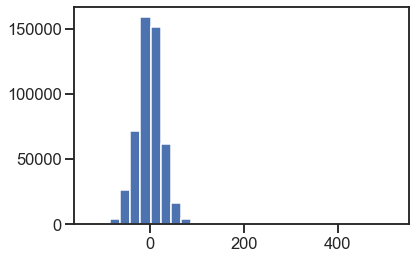

In [27]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False)
reg.fit(elems[le_10].fillna(0), cdf[le_10].enthalpy)
enthalpy_pred = reg.predict(elems[le_10].fillna(0))

ethalpy_err = (cdf[le_10].enthalpy - enthalpy_pred) * 627.509
plt.hist(ethalpy_err, bins=30)

q1 = ethalpy_err.quantile(.25)
q3 = ethalpy_err.quantile(.75)
iqr = q3 - q1

enthalpy_max = q3 + 3 * iqr
enthalpy_min = q1 - 3 * iqr

cdf_small = cdf[le_10][ethalpy_err < enthalpy_max]

In [28]:
cdf_small.shape

(496061, 15)

In [32]:
is_valid = rdf[['molecule', 'fragment1', 'fragment2']].apply(lambda x: x.isin(cdf_small.smiles), 0).all(1)
rdfv = rdf[is_valid]

In [33]:
len(rdf)

1184992

In [34]:
len(rdfv)

1172013

In [36]:
rdfv = rdfv.drop_duplicates(subset=['molecule', 'bond_index'])

In [37]:
rdfv.shape

(816311, 8)

In [41]:
rdfv.mole

,rid,molecule,bond_index,bond_type,fragment1,fragment2,bde,bdfe
0,1643,CC(=O)[C@H](C)O,2,C-C,C[C]=O,C[CH]O,81.637666,67.177976
1,5327,CN1CCN(CCN)CC1,6,C-N,[CH2]CN1CCN(C)CC1,[NH2],87.007888,74.432608
2,5847,OCCc1ncc[nH]1,0,C-O,[CH2]Cc1ncc[nH]1,[OH],97.708799,85.799933
3,5849,OCCc1ncc[nH]1,2,C-C,[CH2]CO,[c]1ncc[nH]1,111.388495,97.257620
4,7480,CCCC(=O)OCC,2,C-C,CCO[C]=O,[CH2]CC,93.436718,79.632775
...,...,...,...,...,...,...,...,...
1184983,1164846,O=C(OC1CC1)[C@@H]1C[C@@H]1F,5,C-C,O=[C]OC1CC1,F[C@@H]1[CH]C1,101.072875,87.088837
1184984,27302,O=C(O)OOC(=O)O,3,O-O,[O]C(=O)O,[O]C(=O)O,38.687185,24.833041
1184988,1928587,CP(C)CCP(C)C,3,C-C,[CH2]P(C)C,[CH2]P(C)C,79.938372,66.121878
1184989,1165608,O=C(OC1CC1)[C@H]1C[C@@H]1F,5,C-C,O=[C]OC1CC1,F[C@@H]1[CH]C1,103.767398,89.844856


In [42]:
from sklearn.model_selection import train_test_split

In [43]:
train, test = train_test_split(rdfv.molecule.unique(), test_size=1000, random_state=1)
train, valid = train_test_split(train, test_size=1000, random_state=1)

In [45]:
rdfv['set'] = 'train'
rdfv.loc[rdfv.molecule.isin(valid), 'set'] = 'valid'
rdfv.loc[rdfv.molecule.isin(test), 'set'] = 'test'

In [47]:
rdfv.to_csv('20200614_rdf_new_elements.csv.gz', compression='gzip', index=False)

In [129]:
rdf_ml[['molecule', 'bond_index']]

,molecule,bond_index
0,CC(=O)[C@H](C)O,2
1,CN1CCN(CCN)CC1,6
2,OCCc1ncc[nH]1,0
3,OCCc1ncc[nH]1,2
4,CCCC(=O)OCC,2
...,...,...
1184983,O=C(OC1CC1)[C@@H]1C[C@@H]1F,5
1184984,O=C(O)OOC(=O)O,3
1184988,CP(C)CCP(C)C,3
1184989,O=C(OC1CC1)[C@H]1C[C@@H]1F,5


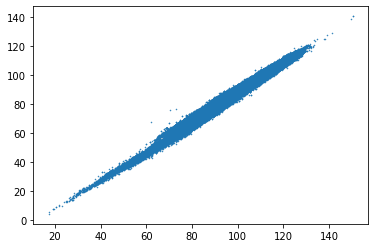

In [130]:
plt.plot(rdf_ml.bde, rdf_ml.bdfe, '.', ms=1)

In [131]:
import dill
with open('tfrecords/preprocessor.p', 'rb') as f:
    preprocessor = dill.load(f)

In [149]:
preprocessor.atom_classes

195

In [150]:
preprocessor.bond_classes

192

In [132]:
preprocessor.max_atoms

32

In [134]:
preprocessor.max_bonds

31

In [136]:
import tensorflow as tf

In [142]:
example = list(tf.data.TFRecordDataset('tfrecords/train.tfrecord.gz', compression_type='GZIP').take(1))[0]

In [143]:
parsed = tf.io.parse_single_example(example, features={
    **preprocessor.tfrecord_features,
    **{'bde': tf.io.FixedLenFeature([], dtype=tf.string),
       'bdfe': tf.io.FixedLenFeature([], dtype=tf.string)}})

# All of the array preprocessor features are serialized integer arrays
for key, val in preprocessor.tfrecord_features.items():
    if val.dtype == tf.string:
        parsed[key] = tf.io.parse_tensor(
            parsed[key], out_type=preprocessor.output_types[key])

# Pop out the prediction target from the stored dictionary as a seperate input
parsed['bde'] = tf.io.parse_tensor(parsed['bde'], out_type=tf.float64)
parsed['bdfe'] = tf.io.parse_tensor(parsed['bdfe'], out_type=tf.float64)

bde = parsed.pop('bde')
bdfe = parsed.pop('bdfe')   

<tf.Tensor: shape=(2, 19), dtype=float64, numpy=
array([[ 96.13061375,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,  80.25024348,  80.25024348,  80.25024348,
        108.6494183 ,          nan,          nan,          nan,
                 nan,          nan,          nan],
       [109.17527084,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,  88.18948735,  88.18948735,  88.18948735,
        117.26448936,          nan,          nan,          nan,
                 nan,          nan,          nan]])>